# Regression: Time Series Forecasting


<img src="https://www.mrtfuelcell.polimi.it/images/logo_poli.jpg" height="200">

**Basi Fondamentali del Machine Learning**

Day 7 - 2024-11-7

Michael Wood, Maciej Sakwa, Emanuele Ogliari

![bouncy balls](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/bouncy_balls.webp?raw=True)


## Outline

1. Machine Learning Project Structure (review)
2. Types of regression
3. Feature engineering
4. Ensemble approaches
5. Deep learning: LSTM


## Learning obejctives
* See how time series regression fits into the machine learning project structure
* Understand each component of SARIMAX
* Follow the concept of Bayes Theorem
* Appreciate the large step in code and file organization of a full, deep learning forecaster


---

# Machine Learning Project Structure (review)

- General project structure is repeated
  - Data changes
  - Model changes

![structure](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/project-structure.png?raw=True)

## 1. Problem definition

**Predict the day-ahead JPL EV charging station power every day at midnight.**

|I/O|  Data | When|
| --- | --- | --- |
|Inputs| `charging_power` | day `d` |
|Target|  `charging_power` | day `d+1`|
|Output| `charging_power_est` | day `d+1` |



## 2. Data collection and engineering

Import the packages

In [1]:
from math import nan
import warnings
import numpy as np

import pandas as pd
from pandas import Timedelta as td
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.plotting.backend='plotly'

def import_data(filepath):
    df = pd.read_csv(filepath,comment='#',index_col=0,parse_dates=True)
    df = df.rename(columns={'Load (kW)':'Load'})
    df = df.resample('1h').mean() # just to establish freq
    df = df['2018-10-15':'2020-2-28'] # cut out startup period and covid
    df[df.Load<0] = nan
    df = df.ffill()
    df = df/10
    df = df[df.index.weekday<4]
    return df.round(1)

def plot_superimpose(ds,days=1,dppd=24,alpha=0.1,title=None):
    pd.options.plotting.backend='matplotlib'
    overlaid = ds.values[:(days*dppd)*(len(ds)//(days*dppd))].reshape(-1,days*dppd).T
    idx = pd.date_range('2024-11-3 0:00',periods=days*dppd,freq='1h') # begin on any given monday
    overlaid = pd.DataFrame(overlaid,index=idx)
    if days==1:
        plt.figure(figsize=(7,5))
    else:
        plt.figure(figsize=(12,5))
    plt.plot(overlaid,alpha=alpha)
    if days==1:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    else:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('Day %w %H:%M'))
    if title is not None:
        plt.title(title)
    plt.ylabel('kW')
    plt.show()
    pd.options.plotting.backend='plotly'


Total station EV charging power, from the US Jet Propulsion Lab (JPL)

In [2]:
data = import_data('https://raw.githubusercontent.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/refs/heads/main/data/ev_charging_station.csv')
data['2019-4-8':'2019-4-11'].plot(title='EV Charging Station Power')

Summary statistics

In [3]:
data.describe()

,Load
count,6912.000000
mean,19.873380
std,23.612089
min,0.000000
25%,0.000000
50%,7.400000
75%,33.900000
max,74.200000


Find statistical outliers (first, save the raw data)

In [4]:
data['LoadRaw'] = data.Load

Use z-score to find outliers

Replace with values from persistence 2 day, 3 day, then 4 day

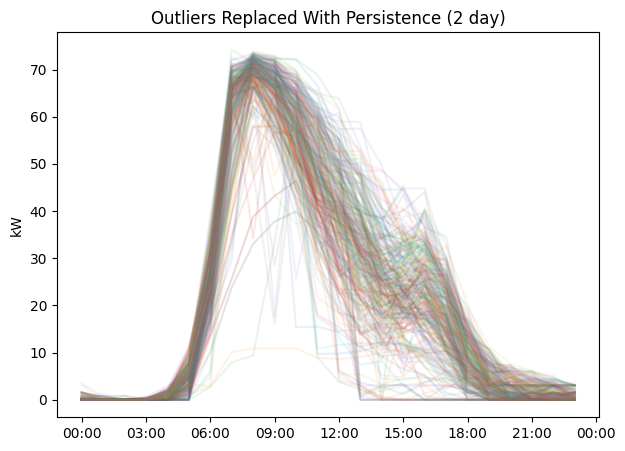

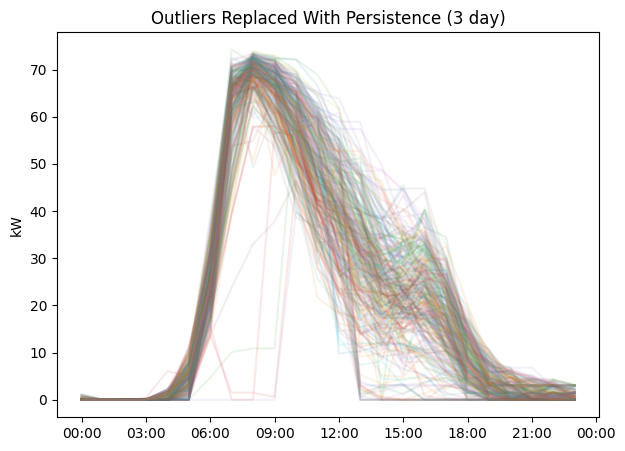

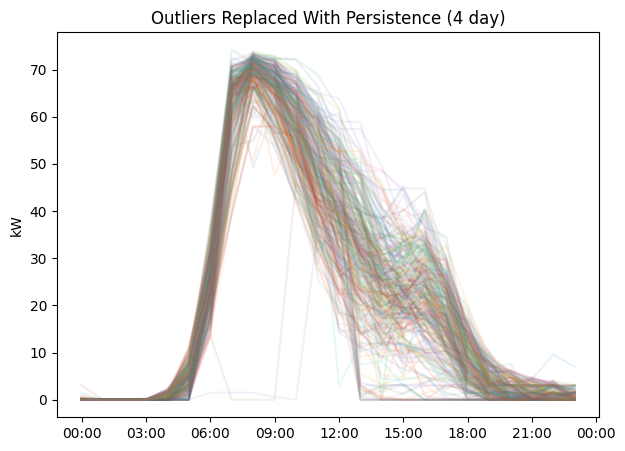

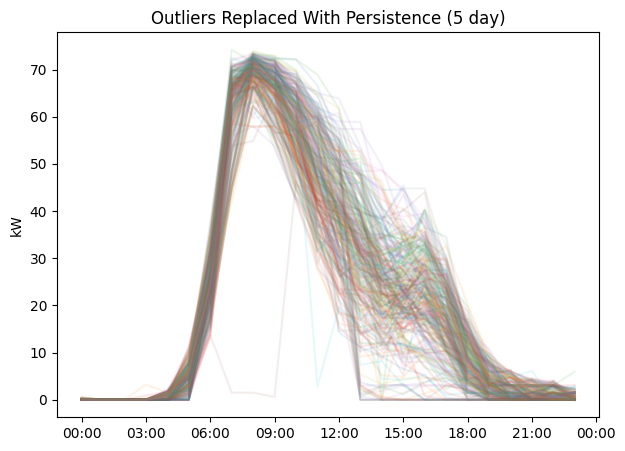

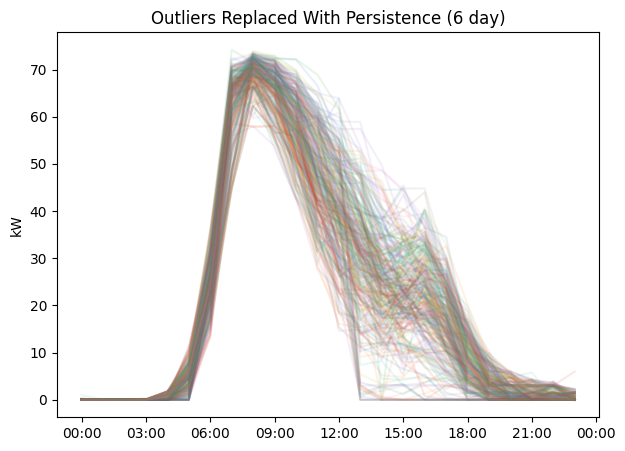

In [5]:
for days in [2,3,4,5,6]:
    x = data.Load
    persist = data.LoadRaw.shift(days*24).rename(f'{days}d').to_frame()

    xDaily = x.values[:24*(len(x)//24)].reshape(-1,24)
    xDaily = pd.DataFrame(xDaily)

    z = (xDaily - xDaily.mean())/xDaily.std()
    data['zscore'] = z.values.flatten()

    data['Load'] = x
    data.loc[data.zscore.abs()>2.5,'Load'] = nan

    data.loc[data.Load.isna().values,'Load'] = persist.loc[data.Load.isna().values,f'{days}d']
    plot_superimpose(data.Load,title=f'Outliers Replaced With Persistence ({days} day)')

Previously we used *correlation* to compare features.

*Autocorrelation* is the correlation between the data, and the *lagged* or shifted version. It measures linear similarity over time.

E.g.

- `corr( data, data.shift('1h') )`
- `corr( data, data.shift('24h') )`

In [6]:
data['Persist_1day'] = data.Load.shift(24)
data.plot(x='Persist_1day',y='Load',kind='scatter',title='Autocorrelation (1 day)')

1 is perfect correlation, 0 is perfect *uncorrelation*

-1 is perfect *inverse* correlation (A goes up, B goes down)

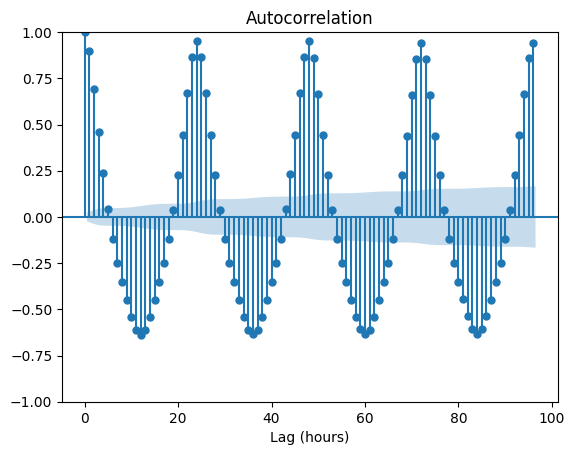

In [7]:
plot_acf(data.Load, lags=4*24);

plt.xlabel('Lag (hours)');
plt.show()

Remember in supervised learning:
- Inputs are **features**
- Outputs are what _do_ come out of the model
- What we _want_ from the model are **targets** (or labels)

For now we don't do any modifications to the **features** we have in the dataset, let's see what results we get with almost *raw* data.

## 3. Model build and train

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Split the inputs and the labels in train and test subgroups

Because we have eliminated weekends and fridays from the data, we need to do a little trick with the datetime index (`real_index`)

In [9]:
data = data[['Load','Persist_1day']]

train_days=7
pred_days=1
test_start_day=30
method='newton'

train_start = test_start_day*24 - train_days*24
test_end    = test_start_day*24 + pred_days*24

df_offset = data[train_start:test_end].copy()
df_offset['real_index'] = df_offset.index
df_offset.index = pd.date_range(df_offset.index[0],
                                periods=len(df_offset),
                                freq='1h')

train_start = df_offset.index[0]
train_end   = train_start + td(days=train_days) - td(hours=1)

test_start = train_end  + td(hours=1)
test_end   = test_start + td(days=pred_days) - td(hours=1)

train = df_offset[train_start:train_end].copy().drop('real_index',axis=1)
test  = df_offset[test_start:test_end  ].copy().drop('real_index',axis=1)

Create model with training data (more on SARIMAX later):

In [10]:
pdq=[2,0,3]
PDQ=[3,0,1]

model = SARIMAX(train.Load,
                order=pdq,
                seasonal_order=PDQ+[24],
                method=method)

Train (`fit`) the model to estimate the targets given the inputs:

In [11]:
model_fit = model.fit( disp=0 )

First we can call the `.predict()` method with *train* inputs:

In [12]:
train['Sarimax'] = model_fit.predict(   start=train_start,
                                        end=train_end,
                                        )

train.index = df_offset[train_start:train_end].real_index

Then we `.predict()` the *test* inputs:

In [13]:
test['Sarimax'] = model_fit.predict(    start=test_start,
                                        end=test_end,
                                        )

test.index = df_offset[test_start:test_end].real_index

Finally evaluate the results:

We can quickly visualise the results with a plot:

In [14]:
test[['Load','Persist_1day','Sarimax']].plot()

## 4. Evaluate results

We'll use Mean Absolute Error (MAE):

* $ MAE = |y_{true}-y_{pred}| $
- $y_{true}$ are the true values
- $y_{pred}$ are the predicted values

And skill:

* $Skill = 1-\frac{error_{SARIMAX}}{error_{Persist 1d}}$

Where the model error is our sarimax and the benchmark is 1-day persistence

In [15]:
def calc_mae(y,ypred):
    return (y-ypred).abs().mean()

mae = dict({'train':dict({ 'sarimax':calc_mae(train.Load,train.Sarimax),
                           'persist':calc_mae(train.Load,train.Persist_1day)}),
            'test':dict({  'sarimax':calc_mae(test.Load,test.Sarimax),
                           'persist':calc_mae(test.Load,test.Persist_1day)})})

skill = dict({  'train':round(1-mae['train']['sarimax']/mae['train']['persist'],3),
                'test':round( 1-mae['test' ]['sarimax']/mae['test' ]['persist'],3)})

skill['test']

0.075

---

# Types of regression

## Linear vs non-linear regression

Linear
- 2d: $y = wx + b$
- 3d: $y = w_1 x_1 + w_2 x_2 + b$

![linreg](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/linreg.png?raw=True)

Non-linear
- Polynomial 2° 2d: $y = wx^2 + b$
- Polynomial 3° 2d: $y = wx^3 + wx^2 + b$
- Exponential: $y = w_0e^{w_1x} + b$

![linreg](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/polyreg.png?raw=True)



## Interpolation vs extrapolation

Interpolation
- Common use is for filling in missing or outlier data
- What might `price actual` be if `price_day_ahead=40`?

![interpolate](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/interpolate.png?raw=True)

Extrapolation
- Common use is to "extend" to model in a new direction
  - e.g. future, past, higher prices
- What might `price actual` be if `price_day_ahead=67.5`?

![extrapolate](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/extrapolate.png?raw=True)



## Autoregression

Single Output

- Only predict one value (red `x`) at each step
- "Recursively" predict future steps
- $y_t = w_1 x_{t-1} + w_2 x_{t-2} + w_3 x_{t-3} + w_4 x_{t-4}$

| |  Inputs | Output|
| --- | --- | --- |
|Step 1| 4 `past` blue dots | first `pred` red dot |
|Step 2| 3 `past` blue dots _and_ first `pred` red dot | second `pred` red dot |
|Step 3| 2 `past` blue dots _and_ first 2 `pred` red dots | third `pred` red dot |


![multistep](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/autoregression_multistep.gif?raw=True)

Multiple Output

- Predict any number of values in one step

![autoregression](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/autoregression.gif?raw=True)


### Autoregression with Moving Average (ARMA)

Moving average (MA) "smooths" the data (and adds a delay)

$MA_t = \frac{1}{P} \sum_0^{P-1} (y_t + y_{t-1} + .. + y_{t-P-1})$

- Where `P` is the "order" (length of window)

ARMA just a sum of the autoregression and moving average

"Synthetic" data example:

In [16]:
P = 10

t = np.linspace(0,10)
x = np.sin(t) + 0.2*np.sin(100*t)
x = pd.DataFrame({'x':x},index=t)

x['MA'] = x.rolling(P).mean()
x.plot(title=f'Moving Average ({P} points)')

### Autoregression with Integrated Moving Average (ARIMA)

Confusing name, "integrated" is not mathematical integration

We do diferrencing on the time series, or `D`-lag persistence

It helps remove effects of seasonality (but not completely)

$DIFF_t = y_t - y_{t-D}$
- Where `D` is how many time steps back to use for difference

In [17]:
D = 1

data['DIFF1'] = data['Load'].diff(D)

data[['Load','DIFF1']][:24].plot(title=f'Differencing (lag {D})')

<ipython-input-17-95d77c89bb6c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Seasonal Autoregression Integrated Moving Average (SARIMA)

- De-seasonalize data with lag: `m`
- One ARIMA for the de-seasonalized data: `P`, `D`, and `Q`
- Another ARIMA for the seasonal component of data: `p`, `d`, `q`

`m` comes from autocorrelation, and for hourly data with a daily seasonality it would be `m=24`


### SARIMAX
- X for exogenous features (coming from outside the system)

## Univariate vs multivariate

Univariate
- One input

| |  Data |
| --- | --- |
|Input| `charging power` |
|Target|  `charging power` |
|Output| `charging power estimate` |

Multivariate
- Multiple inputs

| |  Data |
| --- | --- |
|Inputs| `charging power`, `air temperature` |
|Target|  `charging power` |
|Output| `charging power estimate` |

---
# Feature engineering

(Covariate analysis)

## Endogenous vs exogenous features

Endogenous data
- From "inside" the system
- All data is generated from the same activity of charging EVs

| |  Data |
| --- | --- |
|Inputs| `charging power`, `number of EVs connected` |
|Target|  `charging power` |
|Output| `charging power estimate` |

Exogenous data
- From "outside" the system
- Temperature is _related_ to, but is not interdependent on EV charging power

| |  Data |
| --- | --- |
|Inputs| `charging power`, `air temperature` |
|Target|  `charging power` |
|Output| `charging power estimate` |


## Transformations

Log

In [18]:
data['Log_Transform'] = np.log(data['Persist_1day'].ffill()+1)
data = (data-data.min())/(data.max()-data.min())

corr = data.corr()['Load']['Log_Transform']
corr
data[['Load','Log_Transform']][24:4*24].plot(title=f'Correlation={corr:.3f}')

Square root

In [19]:
data['Root_Transform'] = (data['Persist_1day'].ffill()+1)**(1/2)
data = (data-data.min())/(data.max()-data.min())

corr = data.corr()['Load']['Root_Transform']
corr
data[['Load','Root_Transform']][24:4*24].plot(title=f'Correlation={corr:.3f}')

## Time series decomposition

Find the underlying patterns in the data that together make up the original time series

### Traditional decomposition

- Seasonal/cyclic: often daily, weekly, bi-annual, or annual periodic behavior
- Trend: often a linear increase or decrease over time
- Residual: what remains (often just noise)

This is easier to demonstrate with synthetic data:

In [20]:
date_range = pd.date_range(start='2020-01-01', periods=24*7, freq='H')

trend = np.linspace(10, 20, 24*7)
seasonal = 5 * np.sin(2 * np.pi * date_range.hour / 24)
residual = np.random.normal(0, 1, 24*7)
synthetic_data = trend + seasonal + residual

data_synthetic = pd.Series(synthetic_data, index=date_range, name='Synthetic Load')

Decompose the data

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_synthetic,
                                   model='additive',
                                   period=24)  # Daily seasonality

Plot

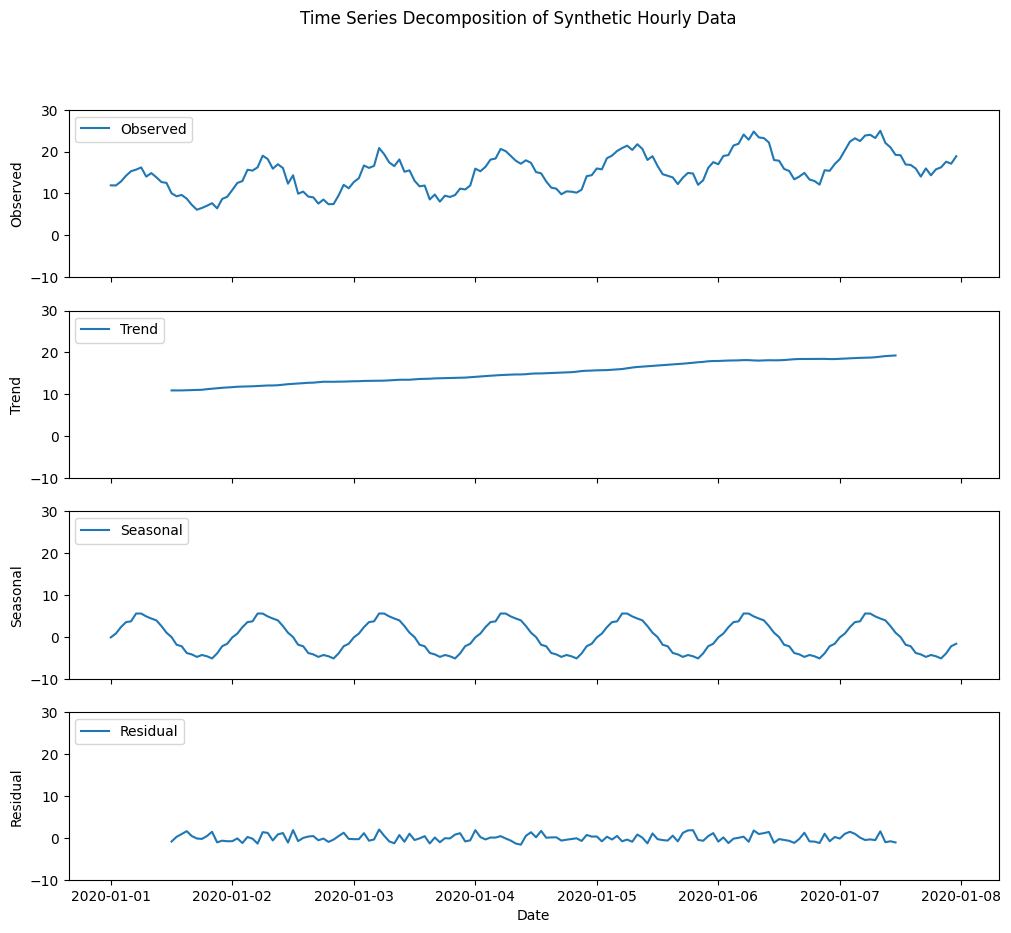

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

ax1.plot(decomposition.observed, label='Observed')
ax1.legend(loc='upper left')
ax1.set_ylabel('Observed')
ax1.set_ylim(-10,30)

ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')
ax2.set_ylim(-10,30)

ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')
ax3.set_ylim(-10,30)

ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')
ax4.set_ylim(-10,30)

plt.suptitle('Time Series Decomposition of Synthetic Hourly Data')
plt.show()

### EMD

Electro cardiograms (EKG) and other signal processing uses have found Empirical Mode Decomposition (EMD) to be very useful in finding patterns in time series data

Here the components aren't so obvious as "seasonality" and "trend," so instead they are named Intrinsic Mode Functions (IMD) with a number 1-to-N (N is the number of IMFs found by EMD)

This next cell installs an emd package, only run it if you are using Colab

In [23]:
!pip install emd-signal

In [24]:
from PyEMD import EMD

emd = EMD()
imfs = emd.emd(data['Load'].values)

Plot

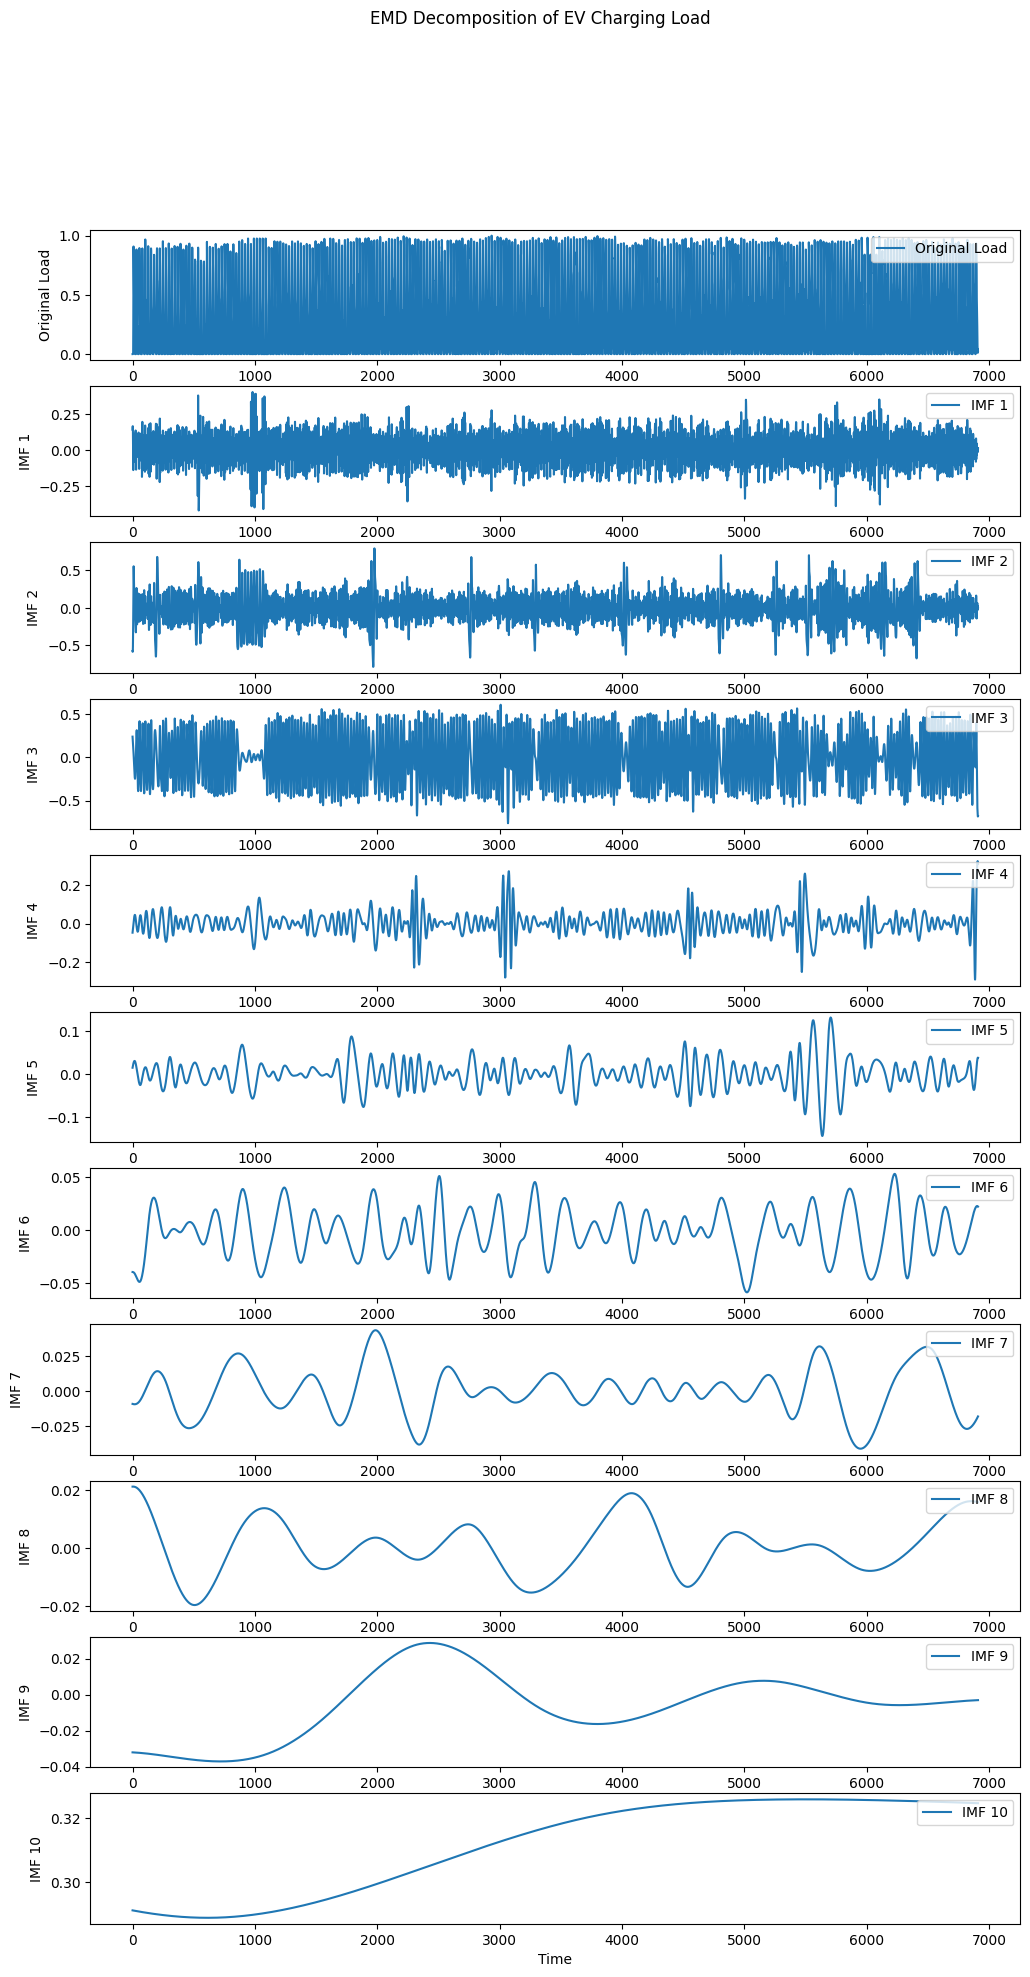

In [25]:
num_imfs = imfs.shape[0]
fig, axes = plt.subplots(num_imfs + 1, 1, figsize=(12, 2 * (num_imfs + 1)))

axes[0].plot(data['Load'].values, label='Original Load')
axes[0].legend(loc='upper right')
axes[0].set_ylabel('Original Load')

for i in range(num_imfs):
    axes[i + 1].plot(imfs[i], label=f'IMF {i + 1}')
    axes[i + 1].legend(loc='upper right')
    axes[i + 1].set_ylabel(f'IMF {i + 1}')

axes[-1].set_xlabel('Time')

plt.suptitle('EMD Decomposition of EV Charging Load')
plt.show()

Can also look at the correlations between IMFs and `Load`

In [26]:
data_imfs=pd.DataFrame(imfs.T)
data_imfs['Load'] = data['Load'].values
data_imfs.corr()[['Load']]

,Load
0,0.011188
1,0.442473
2,0.775038
3,0.056536
4,0.032730
5,0.034249
6,0.018351
7,0.015672
8,0.061806
9,0.060856


---
# Ensemble approaches

Generally, ensemble approaches try to build a set of possible solutions and somehow choose the best one

## Mean of N models

First we define a function to build and train a SARIMAX model

In [27]:
def sarimax_train_and_predict(pdq,PDQ,train_days=7):
    pred_days=1
    test_start_day=30
    method='newton'

    train_start = test_start_day*24 - train_days*24
    test_end    = test_start_day*24 + pred_days*24

    df_offset = data[train_start:test_end].copy()
    df_offset['real_index'] = df_offset.index
    df_offset.index = pd.date_range(df_offset.index[0],
                                    periods=len(df_offset),
                                    freq='1h')

    train_start = df_offset.index[0]
    train_end   = train_start + td(days=train_days) - td(hours=1)

    test_start = train_end  + td(hours=1)
    test_end   = test_start + td(days=pred_days) - td(hours=1)

    train = df_offset[train_start:train_end].copy().drop('real_index',axis=1)
    test  = df_offset[test_start:test_end  ].copy().drop('real_index',axis=1)

    model = SARIMAX(train.Load,
                    order=pdq,
                    seasonal_order=PDQ+[24],
                    method=method)

    model_fit = model.fit( disp=0 )

    train['sarimax'] = model_fit.predict(   start=train_start,
                                            end=train_end,
                                            )

    train.index = df_offset[train_start:train_end].real_index

    test['sarimax'] = model_fit.predict(    start=test_start,
                                            end=test_end,
                                            )

    test.index = df_offset[test_start:test_end].real_index

    mae = dict({'train':dict({ 'sarimax':calc_mae(train.Load,train.sarimax),
                            'persist':calc_mae(train.Load,train.Persist_1day)}),
                'test':dict({  'sarimax':calc_mae(test.Load,test.sarimax),
                            'persist':calc_mae(test.Load,test.Persist_1day)})})

    skill = dict({  'train':round(1-mae['train']['sarimax']/mae['train']['persist'],3),
                    'test':round( 1-mae['test' ]['sarimax']/mae['test' ]['persist'],3)})

    return train, test, skill

**Interactive**

Choose 3 different pdq and PDQ combinations:

In [28]:
train1,test1,skill1 = sarimax_train_and_predict(pdq=[1,1,1],PDQ=[1,1,1])
skill1

{'train': 0.061, 'test': 0.153}

In [29]:
train2,test2,skill2 = sarimax_train_and_predict(pdq=[1,0,1],PDQ=[1,0,1])
skill2

{'train': 0.104, 'test': 0.041}

In [30]:
train3,test3,skill3 = sarimax_train_and_predict(pdq=[2,0,3],PDQ=[3,0,1])
skill3

{'train': 0.112, 'test': 0.034}

Mean is also called "expected value" (good place to start)

In [31]:
test_ensemble = (test1.sarimax + test2.sarimax + test3.sarimax)/3

Plot

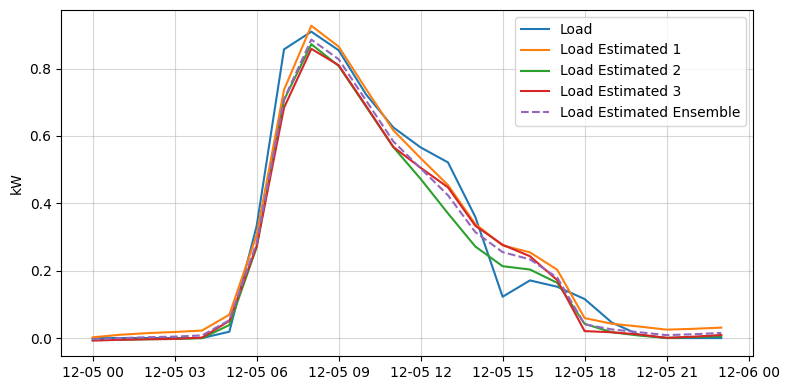

In [32]:
plt.figure(figsize=(8, 4))

plt.plot(test1.Load, label='Load')
plt.plot(test1.sarimax, label='Load Estimated 1')
plt.plot(test2.sarimax, label='Load Estimated 2')
plt.plot(test3.sarimax, label='Load Estimated 3')
plt.plot(test_ensemble, label='Load Estimated Ensemble',linestyle='--')

plt.ylabel('kW')
plt.grid(which='major', alpha = 0.5)

plt.legend()
plt.tight_layout()
plt.show()

## Bayes Theorem

- Fundamental and powerful theorem in statistics
- Main idea: we usually have "prior" knowledge about something before predicting/estimating
- Goal is to *update* our belief with new information, not *replace* it


Simple example
- **Prior:** at the beach in Sardegna in August
- **Likelihood:** phone weather app says snow tomorrow
- **Posterior:** multiplication (union) of prior and likelihood
- **Bayes says:** probably *not* going to snow tomorrow

Bayes Theorem

$$
Posterior = \frac{Likelihood\ \times Prior}{Evidence}
$$


Autonomous Driving Example

![kalman](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/kalman.png?raw=True)


Simplified math: $X_t^{opt} = X_t^{pred} Y_t$


- All letters are probability distributions

- Multiplying two probability distributions together is like finding the "union" of the two

- $X_t^{pred}$ is next estimated car position

- $Y$ is measured car position

- $X_t^{opt}$ is optimal estimate of current car position



Shortcut: product of two normal PDFs with only
- mean $\mu$, and
- standard deviation $\sigma$

$$
\mu_{opt} = {\mu_X \sigma_Y^2 + \mu_Y \sigma_X^2 \over \sigma_X^2 + \sigma_Y^2}, \ \ \ \  \sigma_{opt} =  {\sigma_X^2 \sigma_Y^2 \over \sigma_X^2 + \sigma_Y^2} \\
$$





In [33]:
x = data.Load/data.Load.max()

xDaily = x.values[:24*(len(x)//24)].reshape(-1,24)
xDaily = pd.DataFrame(xDaily,columns=[f'h{x}' for x in range(24)])

x_means = xDaily.mean()
x_stds = xDaily.std()

In [34]:
train,test,skill = sarimax_train_and_predict(pdq=[1,1,1],PDQ=[1,1,1])

In [35]:
test['x_means'] = x_means.values

In [36]:
errors = train.Load - train.sarimax

yDaily = errors.values[:24*(len(errors)//24)].reshape(-1,24)
yDaily = pd.DataFrame(yDaily,columns=[f'h{x}' for x in range(24)])

y_means = yDaily.mean()
y_stds = yDaily.std()

In [37]:
y_means = y_means + test.sarimax.values

In [38]:
opt_means = (x_means + y_stds**2 + y_means * x_stds**2) / (x_stds**2 + y_stds**2)

test['Bayes'] = opt_means.values

test = test/test.max()

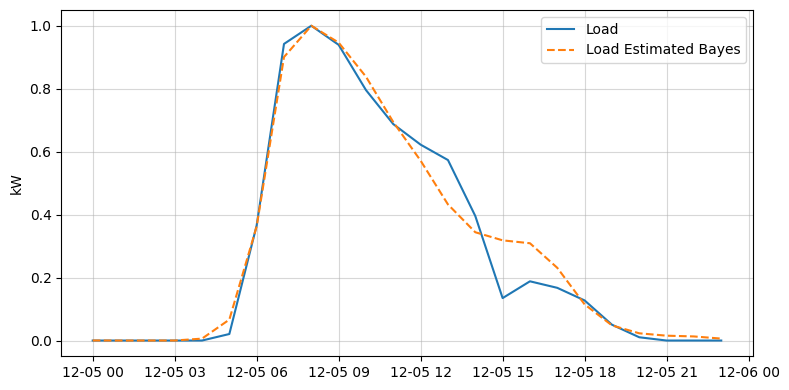

In [39]:
plt.figure(figsize=(8, 4))

plt.plot(test.Load, label='Load')
plt.plot(test.x_means, label='Load Estimated Bayes',linestyle='--')

plt.ylabel('kW')
plt.grid(which='major', alpha = 0.5)

plt.legend()
plt.tight_layout()
plt.show()

---
# Deep Learning approach

## Long Short-Term Memory

- Load `jpl_ev.yaml` into "Files" in Colab


In [40]:
!pip install emd

[]



////////// units_layers=[12, 96] dropout=[0.1, 0.1] n_in=96 loss=mse//////////

////////// features = Load//////////





\\ Training model: u1-12 u2-96 d-[0.1, 0.1] n-96 fs-1




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 96, 12)              │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 96)                  │          41,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 96)                  │           9,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,840 (202.50 KB)

 Trainable params: 51,840 (202.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.0750
Epoch 1: val_loss improved from inf to 0.01163, saving model to ./results/jpl_ev_TEST/lstm.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 96s 390ms/step - loss: 0.0749 - val_loss: 0.0116
Epoch 2/2
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.0191
Epoch 2: val_loss improved from 0.01163 to 0.00737, saving model to ./results/jpl_ev_TEST/lstm.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 80s 358ms/step - loss: 0.0191 - val_loss: 0.0074
Restoring model weights from the end of the best epoch: 2.


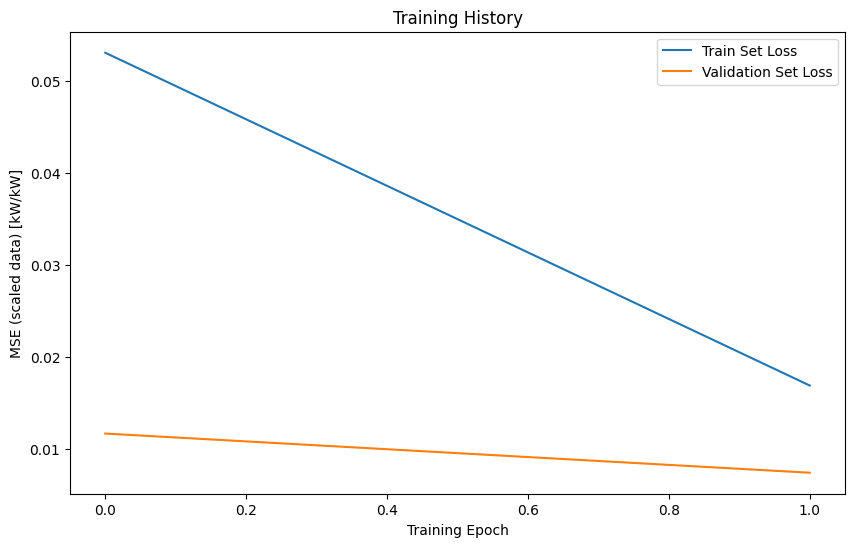

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide

<ipython-input-41-baec66e9d8e0>:865: RuntimeWarning:

invalid value encountered in scalar divide



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Percentage of forecasts with positive skill: 37%
Average skill: -49.9%


In [41]:

__version__ = 1.6

import os, sys, shutil

import yaml

from typing import Generator
from datetime import datetime

from random import shuffle

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
#from statsmodels.tsa.stattools import adfuller # upgrade statsmodels (at least 0.11.1)
#from scipy.stats import shapiro, mode

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.backend import square, mean
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
import emd

print(tf.config.list_physical_devices('GPU'))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#plt.style.use('seaborn-whitegrid')# 'seaborn-whitegrid', 'dark_background')

pd.options.display.float_format = '{:.2f}'.format

np.random.seed(42)
tf.random.set_seed(42)

class dotdict(dict):
    """ Create a dictionary that can be accessed with dot notation
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def read_yaml(config_file:str) -> dotdict:
    """ Open and parse yaml file into dict

    Args:
        config_file (str): Path to yaml file.

    Returns:
        dotdict: _description_
    """
    with open(config_file, 'r') as stream:
        d=yaml.safe_load(stream)
    cfg = dotdict(d)
    return cfg

def model_builder_kt(hp):
    """ In development

    Args:
        hp (_type_): _description_

    Returns:
        _type_: _description_
    """
    n_features_x=1
    n_in=96
    n_out=96
    path_checkpoint=f'lstm.keras'
    dropout=[0,0]
    loss='mse'
    batch_size=256

    model = Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model.add( LSTM(hp_units,
                    return_sequences=True,
                    input_shape=(None, n_features_x,),
                    activation='relu') )

    # if dropout is not None:
    #     if dropout[0] != 0:
    #         model.add(Dropout(dropout[0]))

    # model.add( LSTM( hp_units,
    #                 return_sequences=True,
    #                 activation='relu') )

    if dropout is not None:
        if dropout[1] != 0:
            model.add(Dropout(dropout[1]))

    model.add( Dense( n_out, activation='sigmoid') )

    if loss == 'custom':
        model.compile(loss=Custom_Loss_Prices(),optimizer='adam')
    else:
        model.compile(loss=loss, optimizer='adam')
    model.summary()

    return model

class Custom_Loss_Prices(tf.keras.losses.Loss):
    """ Under development """
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.prices = 7*[1]+5*[5]+12*[1] # 24 hourly "prices" [.1,.1,.1,.1... .3,.3,.3,.3,... 1,1,1] / 20
        self.prices = [self.prices[i//4] for i in range(4*len(self.prices))] # 96 hourly prices
        self.prices_tf = tf.constant(self.prices,dtype=tf.float32)
    def call(self, y_true, y_pred):
        # elements = tf.multiply(x=self.prices_tf, y=tf.abs(y_true - y_pred))
        # elements = y_true - y_pred # for mse
        elements = tf.multiply(x=y_true, y=y_true - y_pred)
        return tf.reduce_mean(tf.square(elements))


class LSTM_EMD:
    """_Define, train, hyperparamter optimze, and test a forecast algorithm based on:
            'Day Ahead Electric Load Forecast: A Comprehensive LSTM-EMD Methodology and Several
            Diverse Case Studies' by M. Wood in MDPI Forecasting (2023)
    """
    def __init__(self,config_file):
        cfg = read_yaml(config_file)
        #self.confg_filepath = config_file
        assert cfg.version == __version__
        self.config = cfg
        self.site = cfg.site
        self.persist_calc_days = cfg.persist_calc_days
        self.data_points_per_day = None
        self.persist_lag = None
        self.results_dir = cfg.results_dir+cfg.site+'/'
        self.clean_dir = cfg.clean_dir
        self.filename = cfg.filename
        self.index_col = cfg.index_col
        self.data_col = cfg.data_col
        self.persist_col = cfg.persist_col
        self.resample = cfg.resample
        self.remove_days=cfg.remove_days # 'weekdays', 'weekdays', or list of ints (0=mon, .., 6=sun)
        self.calendar_features = cfg.calendar_features
        self.model = None
        self.emd = cfg.emd
        self.df = self.get_dat()
        self.peak = self.df['Load'].max()
        self.test_split = cfg.test_split
        self.i_test_split = self.data_points_per_day*int((1-cfg.test_split)*(len(self.df)/self.data_points_per_day))
        self.test_t0 = self.df.index[self.i_test_split]
        self.train = self.df[:self.i_test_split]
        self.valid_split = cfg.valid_split
        self.units_layers = cfg.units_layers
        self.dropout = cfg.dropout
        self.n_in = cfg.n_in
        self.n_out = cfg.n_out
        self.features = cfg.features + [f'{cfg.features_list_name}{i}' for i in cfg.features_list_numbers]
        self.loss = cfg.loss
        self.epochs = cfg.epochs
        self.patience = cfg.patience
        self.plots = cfg.plots
        self.verbose = cfg.verbose
        self.test_plots = cfg.test_plots
        self.test_output = cfg.test_output
        self.batch_size = cfg.batch_size
        self.forecast_freq = cfg.forecast_freq

        self.search = cfg.search
        self.units1 = cfg.units1
        self.units2 = cfg.units2
        self.dropouts = cfg.dropouts
        self.ns = cfg.ns
        self.features_2D = cfg.features_2D

        if not os.path.exists('./results'):
            os.mkdir('./results')
        if not os.path.exists(self.results_dir):
            os.mkdir(self.results_dir)
        else:
            if self.clean_dir:
                input('\nWarning: deleting existing files (hit enter): ')
                shutil.rmtree(self.results_dir)
                os.mkdir(self.results_dir)

        #shutil.copyfile(os.path.basename(__file__), self.results_dir+os.path.basename(__file__))
        shutil.copyfile(config_file, self.results_dir+config_file)


    def min_max_scaler(self,df:pd.DataFrame)->pd.DataFrame:
        """ Replacement for statstools minmax scaler

        Args:
            df (pd.DataFrame): data to scale

        Returns:
            pd.DataFrame: scaled data
        """
        xmins,xmaxs = [],[]
        for col in df.columns:
            xmin = df[col].minx()
            xmax = df[col].max()
            df[col] = (df[col] - xmin)/(xmax-xmin)
            xmins.append(xmin)
            xmaxs.append(xmax)
            self.scalers = pd.DataFrame({'xmin':xmins,'xmax':xmax}).T
            self.scalers
        return df

    def emd_sift(self, df:pd.DataFrame)->pd.DataFrame:
        """ Empirical Mode Decomposition receives a single vector of data and decomposes it into
            Intrinsic Mode Functions (IMFs) which typically number in the 10-12 range. Each IMF
            is a component of the original vector and all IMFs summed together necessarily equal the
            original vector. The first IMF is the most rapid oscillation and the last IMF is the
            "residual" which may have no oscillations.

        Args:
            df (pd.DataFrame): dataframe containing only one vector of time series data

        Returns:
            pd.DataFrame: original dataframe with new columns for each IMF
        """
        imf = emd.sift.sift(df['Load'].values)

        for i in range(imf.shape[1]):
                df['IMF%s'%(i+1)] = imf[:,i]

        return df


    def get_dat(self)->pd.DataFrame:
        """ Read and preprocess load data. Resultant data will have a complete index and no bad
            data such as NaNs of inf. Data should be mostly clean to begin with, especially no large
            missing sections.

        Returns:
            pd.DataFrame: data with datetime index (not tz aware)
        """
        usecols = [self.index_col,self.data_col]
        if self.persist_col is not None:
            usecols = usecols + [self.persist_col]

        df = pd.read_csv(self.filename,
                            comment='#',
                            parse_dates=True,
                            index_col=usecols[0],
                            #usecols=usecols
                            )
        df = df.rename(columns = {self.data_col:'Load'})

        df = df.ffill().bfill()

        if self.resample != False:
            df = df.resample(self.resample).mean()

        interval_min = int(df.index.to_series().diff().mode()[0].seconds/60)
        self.data_points_per_day = int(1440/interval_min)
        if self.persist_calc_days:
            self.persist_lag = self.persist_calc_days * self.data_points_per_day
            if self.persist_col is None and 'Persist' not in df.columns:
                df['Persist'] = df['Load'].shift(self.persist_lag)

        # drop units from any column headers
        df.columns = [x.split('[')[0] for x in df.columns]
        df.columns = [x.split('(')[0] for x in df.columns]

        df = df.rename(columns = {self.data_col:'Load'})
        # if self.persist_col is None:
        #     df['Persist'] = df['Load'].shift(self.persist_lag)
        # else:
        #     df = df.rename(columns = {self.persist_col:'Persist'})

        df['Weekday'] = df.index.weekday

        #df = df.tz_localize('Etc/GMT+8',ambiguous='infer') # or 'US/Eastern' but no 'US/Pacific'

        #df = df.tz_convert(None)
        df = df.ffill().bfill()

        # if self.resample != False:
        #     df = df.resample(self.resample).mean()

        if self.remove_days is not None:
            if self.remove_days == 'weekends':
                df = df[df.index.weekday < 5 ]
            elif self.remove_days == 'weekdays':
                df = df[df.index.weekday >= 5 ]
            elif isinstance(self.remove_days,list):
                for day in self.remove_days:
                    df = df[df.index.weekday != day]
            else:
                print('remove_days must be "weekends", "weekdays", or a list of integers')
                sys.exit()

        if self.emd:
            df = self.emd_sift(df)

        if self.calendar_features:
            df['Day'] = df.index.dayofyear
            df['Hour'] = df.index.hour
            df['Weekday'] = df.index.dayofweek

        #df['Persist'] = df['Load'].shift(self.persist_lag)

        df = df.ffill().bfill()

        return df


    def batch_generator_v3( self,
                              batch_size:int,
                              n_in:int,
                              n_out:int,
                              n_x_features:int,
                              n_y_targets:int,
                              n_samples:int,
                              x:int,
                              y:int,
                              randomize=True,):
        """
        Generator function for creating random batches of training-data.

        Args:
            batch_size (int): number of input-vector and output-vector pairs per batch
            n_in (int): lenth of input x vector
            n_out (int): length of output y vector
            n_x_features (int): number of input features
            n_y_targets (int): numer of output targets
            n_samples (int): total number of training set measurements
            x (int): vector of input measurements (shifted ahead by n_in)
            y (int): vector of output measurements
            randomize (bool, optional): option to shuffle each input-output vector pair. Defaults
                to True.
            daily (bool optional): rather than train as if forecast is performed at any arbitrary
                time in the test data, only train for forecasts which are performed exactly at
                midnight.

        Yields:
            _type_: _description_
        """

        while True:
                # Allocate a new array for the batch of input-signals
                x_shape = (batch_size, n_in, n_x_features)
                x_batch = np.zeros(shape=x_shape, dtype=np.float16)

                # Allocate a new array for the batch of output-signals
                y_shape = (batch_size, n_out, n_y_targets)
                y_batch = np.zeros(shape=y_shape, dtype=np.float16)

                # Fill the batch with random sequences of data
                for i in range(batch_size):
                        # Get a random start-index
                        # This points somewhere into the training-data
                        if randomize:
                            idx = np.random.randint(n_samples - n_in - n_out)
                        # or not
                        else:
                            idx = i

                        # Copy the sequences of data starting at this index
                        x_batch[i] = x[idx:idx+n_in]
                        y_batch[i] = y[idx:idx+n_out]

                yield (x_batch, y_batch)


    def organize_dat_v4(self,
                        df:pd.DataFrame,
                        n_in:int,
                        n_out:int,
                        valid_split:int,
                        batch_size:int,):
        """ Structure data for supervised learning

        Args:
            df (pd.DataFrame): data
            n_in (int): input vector length
            n_out (int): output vector length
            valid_split (int): number of values to be used for validation
            batch_size (int): number of input-output pairs per batch

        Returns:
            tuple: (n_x_signals, n_y_signals, train_generator, valid_data, y_scaler)
        """

        # scalers
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()

        # shift for forecast
        #shift_steps = 1 * 24 * 4    # Number of time steps
        df_targets = df['Load'].shift(-1*n_in)

        # scale and adjust the length

        x_data = x_scaler.fit_transform(df.values)[:-1*n_in]
        y_data = y_scaler.fit_transform(df_targets.values[:-1*n_in,np.newaxis])
        #y_data = np.expand_dims(y_data,axis=1)


        dump(x_scaler, open(self.results_dir + "x_scaler.pkl", 'wb'))
        dump(y_scaler, open(self.results_dir + "y_scaler.pkl", 'wb'))

        n_x = len(x_data)
        n_train = int((1-valid_split) * n_x//self.data_points_per_day)*self.data_points_per_day
        #num_valid = num_data - num_train

        x_train = x_data[:n_train]
        x_valid = x_data[n_train:]# if n_train<n_x else None
        #len(x_train) + len(x_valid)

        y_train = y_data[:n_train]
        y_valid = y_data[n_train:]# if n_train<n_x else None
        #len(y_train) + len(y_test)

        n_x_signals = x_data.shape[1]
        n_y_signals = y_data.shape[1]

        train_generator = self.batch_generator_v3(batch_size,
                                            n_in,
                                            n_out,
                                            n_x_signals,
                                            n_y_signals,
                                            n_train,
                                            x_train,
                                            y_train)

        randomize=False
        n_samples = x_valid.shape[0]
        batch_size = x_valid.shape[0] - n_in - n_out

        x_shape = (batch_size, n_in, n_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, n_out, n_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
                # Get a random start-index.
                # This points somewhere into the training-data.
                if randomize:
                    idx = np.random.randint(n_samples - n_in - n_out)
                else:
                    idx = i

                # Copy the sequences of data starting at this index.
                x_batch[i] = x_valid[idx:idx+n_in]
                y_batch[i] = y_valid[idx:idx+n_out]

        valid_data = (x_batch,y_batch)



        #valid_data = ( np.expand_dims(x_valid, axis=0),np.expand_dims(y_valid, axis=0))

        return (n_x_signals, n_y_signals, train_generator, valid_data, y_scaler)

    def organize_dat_test(self, df:pd.DataFrame):
        """ Organize data for testing

        Args:
            df (pd.DataFrame): data

        Returns:
            np.array: array of x (input) data
        """

        x_scaler = load(open(self.results_dir + "x_scaler.pkl", 'rb'))

        x_test = x_scaler.transform(df.values)

        return np.expand_dims(x_test, axis=0)

    def train_lstm_v6(self,
                      n_features_x:int,
                      n_in:int,
                      n_out:int,
                      path_checkpoint:str,
                      train:Generator,
                      valid,
                      units_layers:list,
                      epochs:int,
                      patience=10,
                      verbose=1,
                      dropout:float=None,
                      afuncs={'lstm':'relu','dense':'sigmoid'},
                      learning_rate=1e-3,
                      loss='mse',
                      batch_size=32,
                      steps:int=None):
        """ Define and train LSTM model

        Args:
            n_features_x (int): number of parallel vectors to be used as input
            n_in (int): length of inputs
            n_out (int): length of outputs
            path_checkpoint (str): filename to save best model
            train (Generator): generator object to produce training data
            valid (np.array): validation data
            units_layers (list of int): first number is the 1st layer units, second number is the
                2nd layer units (can be 0 ie no 2nd layer)
            epochs (int): maximum number of epochs to trian for
            patience (int, optional): how many epochs to wait for validation to loss to decrease
                before stopping training. Defaults to 10.
            verbose (int 0-2, optional): how much output information to give while training. Defaults to 1.
            dropout (float, optional): dropout value for each layer. Defaults to None.
            afuncs (dict, optional): activation functions to use for the lstm and ann layers.
                Defaults to {'lstm':'relu','dense':'sigmoid'}.
            learning_rate (float, optional): adam initial learning rate. Defaults to 1e-3.
            loss (str, optional): training loss function. Defaults to 'mse'.
            batch_size (int, optional): number of input-output pairs in each training batch.
                Defaults to 32.
            steps (int, optional): alternative to defining batch_size, can define how many batches
                to divide entire training data into. Defaults to None.

        Returns:
            tuple: (trained tf model, training history)
        """

        print(f'\n\n\\\ Training model: u1-{units_layers[0]} u2-{units_layers[1]} d-{dropout} n-{n_in} fs-{n_features_x}\n\n')

        model = Sequential()


        #model.add(Input(shape=(n_in,n_features_x)))

        if units_layers[1] == 0:

            model.add( LSTM(units_layers[0],
                            #return_sequences=True,
                            input_shape=(n_in, n_features_x,),
                            activation=afuncs['lstm']) )

            if dropout is not None:
                if dropout[0] != 0:
                    model.add(Dropout(dropout[0]))

        else:

            model.add( LSTM(units_layers[0],
                            return_sequences=True,
                            input_shape=(n_in, n_features_x,),
                            activation=afuncs['lstm']) )

            if dropout is not None:
                if dropout[0] != 0:
                    model.add(Dropout(dropout[0]))

            model.add( LSTM( units_layers[1],
                            #return_sequences=True,
                            activation=afuncs['lstm']) )

            if dropout is not None:
                if dropout[1] != 0:
                    model.add(Dropout(dropout[1]))

        model.add( Dense( n_out, activation=afuncs['dense']) )

        if loss == 'custom':
            model.compile(loss=Custom_Loss_Prices(),
                          optimizer=Adam(learning_rate=learning_rate),)
        else:
            model.compile(loss=loss,
                          optimizer=Adam(learning_rate=learning_rate),)
        model.summary()

        callback_checkpoint = ModelCheckpoint(  filepath=path_checkpoint,
                                                monitor='val_loss',
                                                verbose=verbose,
                                                #save_weights_only=True,
                                                save_best_only=True)

        callback_early_stopping = EarlyStopping(    monitor='val_loss',
                                                    patience=patience,
                                                    verbose=verbose,
                                                    restore_best_weights=True)

        callback_terminate_on_nan = TerminateOnNaN()

        # callback_tensorboard = TensorBoard( log_dir='./logs/',
        #                                     histogram_freq=0,
        #                                     write_graph=False)

        callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.01,
                                                min_lr=1e-4,
                                                patience=5,
                                                verbose=verbose)

        # reduce_lr_loss = ReduceLROnPlateau(monitor='loss',
        #                                     factor=0.1,
        #                                     patience=patience_lr,
        #                                     verbose=1,
        #                                     epsilon=1e-4,
        #                                     mode='min')

        callbacks = [ callback_early_stopping,
                    callback_checkpoint,
                    callback_terminate_on_nan,
                    #callback_tensorboard,
                    #callback_reduce_lr,
                    ]

        if steps is None:
            steps = (len(self.train) - valid[0].shape[0] - n_in - n_out)//batch_size

        hx = model.fit( x=train,
                        epochs=epochs,
                        #batch_size=batch_size,
                        steps_per_epoch=steps,
                        validation_data=valid,
                        #validation_split=self.valid_split,
                        callbacks=callbacks,
                        verbose=verbose)

        return (model, hx)


    def get_callbacks(self, name_weights:str, patience_lr:float):
        """ Callbacks to save best model and reduce learning rate on plateau

        Args:
            name_weights (str): filename for weights
            patience_lr (float): patience learning rate

        Returns:
            list: model checkpoint save, reduced learnign rate
        """
        mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
        return [mcp_save, reduce_lr_loss]


    def plot_training_history(self,hx):
        """ Plot training history as epochs vs training loss and validation loss

        Args:
            hx (tf object): history from tf model training
        """
        hx_loss = hx.history['loss']
        hx_val_loss = hx.history['val_loss']
        t = np.arange(len(hx_loss))

        plt.figure(figsize=(10,6))
        plt.plot(t,hx_loss,t,hx_val_loss)
        plt.legend(['Train Set Loss','Validation Set Loss'])
        plt.ylabel('MSE (scaled data) [kW/kW]')
        plt.xlabel('Training Epoch')
        plt.title('Training History')
        plt.show()


    def build_and_train(self,
                      units_layers:list=None,
                      dropout:list=None,
                      features:str=None,
                      n_in:int=None,
                      n_out:int=None,
                      epochs:int=None,
                      patience:int=None,
                      verbose:int=None,
                      plots:bool=None,
                      test_split:float=None,
                      valid_split:float=None,
                      batch_size:int=None,
                      loss:str=None):
        """ Organize data, train, and save new model. All optional arguments are first defined
            in config file but can be overridden here.

        Args:
            units_layers (list, optional): Override LSTM layer 1 and 2 (can be 0) units. Defaults to None.
            dropout (list, optional): Override both LSTM layer 1 and 2 dropout. Defaults to None.
            features (str, optional): Override feature list. Defaults to None.
            n_in (int, optional): Override length of input vector. Defaults to None.
            n_out (int, optional): Override length of output vector. Defaults to None.
            epochs (int, optional): Override max number of training epochs. Defaults to None.
            patience (int, optional): Override nubmer of epochs to wait before stopping training. Defaults to None.
            verbose (int 0-2, optional): Override tf training output. Defaults to None.
            plots (bool, optional): Override plots on/off. Defaults to None.
            test_split (float, optional): Override fraction of data for testing . Defaults to None.
            valid_split (float, optional): Override fraction of data for validation. Defaults to None.
            batch_size (int, optional): Override number of input-output pairs for each training batch. Defaults to None.
            loss (str, optional): Override training loss function. Defaults to None.

        Returns:
            tf history object: training history
        """

        if units_layers is not None:
            self.units_layers = units_layers
        if dropout is not None:
            self.dropout = dropout
        if features is not None:
            self.features = features
        if n_in is not None:
            self.n_in = n_in
        if n_out is not None:
            self.n_out = n_out
        if epochs is not None:
            self.epochs = epochs
        if patience is not None:
            self.patience = patience
        if plots is not None:
            self.plots = plots
        if verbose is not None:
            self.verbose = verbose
        if test_split is not None:
            self.test_split = test_split
        if valid_split is not None:
            self.valid_split = valid_split
        if batch_size is not None:
            self.batch_size = batch_size
        if loss is not None:
            self.loss = loss


        #self.units = units
        #self.layers = layers
        units_layers = self.units_layers
        units = units_layers
        layers = len(units_layers)
        features = self.features
        dropout = self.dropout
        test_split = self.test_split
        valid_split = self.valid_split
        batch_size = self.batch_size
        loss = self.loss
        plots = self.plots
        verbose = self.verbose
        epochs = self.epochs
        patience = self.patience

        df = self.train[self.features]

        print(f'\n\n\n////////// units_layers={units_layers} dropout={dropout} n_in={self.n_in} loss={loss}//////////')
        print(f"\n////////// features = {', '.join(features)}//////////\n\n\n")

        # meta
        y, m, d = datetime.now().year-2000, datetime.now().month, datetime.now().day
        path_checkpoint = self.results_dir+ f'lstm.keras'

        ( n_features_x, n_features_y,
            train_gen, valid_data,
            scaler) = self.organize_dat_v4( df, self.n_in, self.n_out, valid_split, batch_size)

        #(x_valid, y_valid) = dat_valid

        # np
        #y_valid_naive_mse = naive_forecast_mse( y_valid[0,:,0],horizon=self.persist_lag)

        # model
        self.model, history = self.train_lstm_v6(  n_features_x, self.n_in, self.n_out,
                                    path_checkpoint, train_gen, valid_data,
                                    units_layers, epochs,
                                    patience, verbose, dropout,loss=loss,batch_size=batch_size)

        if plots is not None:
            if plots == 'hx':
                self.plot_training_history(history)

        return history


    def test_multiple(self,t0:str=None,test_output=None,test_plots=None,limit=None,):
        """ Quickly test forecast on test data starting at t0

        Args:
            t0 (str, optional): Can specify a starting datetime. Defaults to None.
            test_output (bool, optional): Can turn on/off each test forecast output. Defaults to None.
            test_plots (bool, optional): Can tun on/off each test forecast plot. Defaults to None.
            limit (int, optional): Can limit number of tests. Defaults to None.

        Returns:
            _type_: _description_
        """

        if test_output is not None:
            self.test_output = test_output
        if test_plots is not None:
            self.test_plots = test_plots
        output = self.test_output
        plots = self.test_plots

        if t0 is None:
            t0 = self.test_t0
        else:
            t0 = pd.to_datetime(t0)

        if t0 < self.test_t0:
            print(f'Bad idea to begin testing on training data, changing start of the test to {self.test_t0}')
            t0 = self.test_t0


        #print(self.features);print(self.df.columns)

        if 'Persist' not in self.features:
            df = self.df[self.features + ['Persist']]
        else:
            df = self.df[self.features]

        #print(df.columns);sys.exit()

        y_scaler = load(open(self.results_dir + "y_scaler.pkl", 'rb'))
        if self.loss == 'custom':
            model = tf.keras.models.load_model(self.results_dir+"lstm.keras",
                                                custom_objects={'Custom_Loss_Prices':Custom_Loss_Prices,})
        else:
            model = tf.keras.models.load_model(self.results_dir+"lstm.keras")

        times = []
        skills_mae,maes_pers,maes_lstm = [],[],[]
        skills_mape,mapes_pers,mapes_lstm = [],[],[]
        mases = []

        all_forecasts = pd.DataFrame([])

        i0 = self.df.index.get_loc(t0)
        hours_remaining = (len(df.index) - i0)//4 - 48
        days_remaining = hours_remaining//24
        if limit is not None:
            hours_remaining = limit

        if self.forecast_freq == '1h':
            k = 4
            remaining = hours_remaining
        elif self.forecast_freq == '1d':
            k = 96
            remaining = days_remaining
        for t in [df.index[i0+k*x] for x in range(remaining)]:

            if self.test_output:print(t)

            x = df.loc[:t-pd.Timedelta('15min'),self.features][-1*self.n_in:].copy()

            y_true = df.loc[t:,'Load'][:self.n_out].copy()
            y_pers = df.loc[t:,'Persist'][:self.n_out].copy()

            mae_pers = (y_true-y_pers).abs().mean()
            mape_pers = ((y_true - y_pers).abs() / y_true).mean()

            if mae_pers < 0.001:
                if output:
                    print ('\nPersistence == perfect')
            elif t != y_true.index[0]:
                if output:
                    print ('\nWeekday doesnt exist in training data')
            else:
                x_test = self.organize_dat_test(x)

                y_pred = model.predict(x_test[:,-1*self.n_in:,:])

                y_pred = pd.Series(y_scaler.inverse_transform(y_pred).flatten(),
                                   index=y_true.index,
                                   name='Pred')

                mae_lstm = (y_true - y_pred).abs().mean()
                mape_lstm = ((y_true - y_pred).abs() / y_true).mean()

                skill_mae = 1 - mae_lstm / mae_pers
                skill_mape = 1 - mape_lstm / mape_pers

                mase = (y_true - y_pred).abs().mean() / (y_true - y_pers).abs().mean()

                forecast = pd.concat((y_pred,y_true,y_pers),axis=1)

                if plots:
                    title = f'Skill {skill_mae:.3f}'
                    forecast.plot(title=title)
                    plt.show()

                forecast['timestamp_update'] = t
                forecast['timestamp'] = forecast.index
                forecast.index = range(len(all_forecasts),len(all_forecasts)+len(forecast))
                all_forecasts = pd.concat((all_forecasts,
                                           forecast),axis=0)

                times.append(t)
                skills_mae.append(skill_mae)
                maes_pers.append(mae_pers)
                maes_lstm.append(mae_lstm)
                skills_mape.append(skill_mape)
                mapes_pers.append(mape_pers)
                mapes_lstm.append(mape_lstm)
                mases.append(mase)


        all_forecasts.to_csv(f'{self.results_dir}/all_forecasts.csv')

        pd.DataFrame({'timestamp_update':times,
                      'skill_mae':skills_mae,
                      'mae_pers':maes_pers,
                      'mae_lstm':maes_lstm,
                      'skill_mape':skills_mape,
                      'mape_pers':mapes_pers,
                      'mape_lstm':mapes_lstm,
                      'mase':mases,}
                      ).round(3).to_csv(f'{self.results_dir}/errors.csv')

        skills = np.array(skills_mae)
        print('Percentage of forecasts with positive skill:',
              f'{100*len(skills[skills>0])/len(skills):.0f}%')
        print(f'Average skill: {100*skills.mean():.1f}%')

        return skills.mean(), len(skills[skills>0])/len(skills)

    def random_search(self,
                              units1:list=None,
                              units2:list=None,
                              dropout:list=None,
                              n_in:list=None,
                              features:list=None):
        """ Random search for best hyperparameters

        Args:
            units1 (list of int): all possible values for the first LSTM layer (cannot be 0)
            units2 (list of int): all possible values for the second LSTM layer (can be 0)
            dropout (list of float): all possible values for dropout (can be 0, typically < 0.3)
            n_in (list of int): all possible lengths of input vector
            features (list of str): all possible combinations of features
        """
        main_results_dir = self.results_dir
        units1 = units1 if units1 is not None else self.units1
        units2 = units2 if units2 is not None else self.units2
        dropout = dropout if dropout is not None else self.dropouts
        n_in = n_in if n_in is not None else self.ns
        features = features if features is not None else self.features_2D

        # what are the already completed models?
        search_space_completed = []
        # files = next(os.walk(main_results_dir))[1]
        # for s in files:
        #     u1 = int( s.split('_')[0][1:].split('-')[0] )
        #     u2 = int( s.split('_')[0][1:].split('-')[1] )
        #     d = float( s.split('_')[1][1:] )
        #     n = int( s.split('_')[2][1:] )
        #     fs = int( s.split('_')[3][1:] )
        #     search_space_completed.append({'u1':u1,'u2':u2,'d':d,'n':n,'fs':fs})

        # build search space
        search_space = []
        for u1 in units1:
            for u2 in units2:
                for d in dropout:
                    for n in n_in:
                        for f in features:
                            search_space.append({'u1':u1,'u2':u2,'d':d,'n':n,'f':f})
        shuffle(search_space)


        # walk through search space
        results = pd.DataFrame([],columns=['u1','u2','d','n','f','skMean','skPos','e'])
        for s in [x for x in search_space if x not in search_space_completed]: # exlude existing
            try:
                u1,u2,d,n,fs = s['u1'],s['u2'],s['d'],s['n'],len(s['f'])
                self.results_dir = main_results_dir + f'u{u1}-{u2}_d{d}_n{n}_f{fs}/'

                if not os.path.exists(self.results_dir):
                    os.mkdir(self.results_dir)
                h = self.build_and_train(units_layers=[u1,u2],
                                            dropout=[d]*2,
                                            n_in=n,
                                            features=f)
                mean_skill, positive_skills = self.test_multiple()
                r = {'skMean':mean_skill,'skPos':positive_skills,'e':len(h.history['loss'])}
                s.update(r)
                s['f'] = len(s['f'])
                results.loc[len(results)] = s
                results.to_csv(main_results_dir+'/results.csv')
                #self.analyze_hyperparam_search()
            except:
                pass

    def analyze_hyperparam_search(self):
        """ Calculate best models from hyperparameter search
        """
        dirs = next(os.walk(self.results_dir))[1]
        results = pd.DataFrame({'model':[],'mean_skill':[]})
        for d in dirs:
            files = os.listdir(self.results_dir+d)
            if 'errors.csv' in files:
                e = pd.read_csv(self.results_dir+d+'/errors.csv',index_col=1,parse_dates=True)
                mean_skill = e.skill_mae.mean().round(3)
                results.loc[len(results)] = {'model':d,'mean_skill':mean_skill}
        results = results.sort_values(by=['mean_skill'],ascending=False)
        results.to_csv(self.results_dir+'results_summary.csv')
        print(results)

if __name__ == '__main__':
    jpl = LSTM_EMD('jpl_ev.yaml')

    history = jpl.build_and_train()

    jpl.test_multiple()
